# Feature engineering on extracted Pull Requests data


## What we did previously

In the previous step, we collected data from a Github repository of choice and store them on S3 storage

## In this step

In this notebook we will walk through how to start analyzing the PR data collected from a Github repository.

We explore the various fields in the PR dataset and the features that we can derive from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

In [1]:
import os
import re
import gzip
import json
import pathlib
import datetime
from tqdm import tqdm
from io import BytesIO
from pathlib import Path
from functools import partial
from collections import Counter
from github import Github

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv

In [2]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv(), override=True)

True

In [3]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials

RAW_DATA_PATH = os.path.join(ORG, REPO)
TOKEN = os.getenv("GITHUB_ACCESS_TOKEN")

In [9]:
# Collect PRs and combine them

# how many files of the given extension were changed in PR
CLOSED_PR_IDS_FILENAME = os.path.join("CLOSED_PR_IDS.parquet")

PR_ID_DF = pd.read_parquet(CLOSED_PR_IDS_FILENAME, engine='pyarrow')

pr_ids = list(PR_ID_DF['closed_pr_ids'])

appended_prs = []
for pr_id in pr_ids:
    PR_PATH = os.path.join("PRs/"+ str(pr_id) + ".json")
    pr = pd.read_json(PR_PATH)

    appended_prs.append(pr)

appended_prs = pd.concat(appended_prs)

In [10]:
appended_prs.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
0,added version to point to latest on marketplace,Pointed action version to latest https://githu...,XXL,oindrillac,2023-02-03 15:08:51,2023-02-03 20:44:07,oindrillac,NaT,NaN,4,4,{'github-actions[bot]': 32},"{'1283185249': {'author': 'aakankshaduggal', '...",[],"[43842a56304db8f51d2452702dbe893c992bd67f, 1a3...","[.github/workflows/inference.yaml, 02_notebook...",2023-02-03 15:37:49,NaT
0,adding branding to action pre-publishing,SSIA,XS,oindrillac,2023-01-27 19:19:21,2023-01-30 14:39:00,oindrillac,2023-01-30 14:39:00,oindrillac,1,1,{},"{'1273400914': {'author': 'MichaelClifford', '...",[],[e1fcc18715a07c020b7809b464255b2adf61e35c],[action.yml],2023-01-27 20:12:01,2023-01-27 20:12:01
0,formatted inference messaging,Formatted inference output. Modified messaging...,M,oindrillac,2023-01-27 16:28:49,2023-01-27 18:51:23,oindrillac,2023-01-27 18:51:23,oindrillac,1,1,{},"{'1273079367': {'author': 'aakankshaduggal', '...",[],[21fd675b28af2d7e686bdfeede650455677218b1],[04_model_inference.ipynb],2023-01-27 17:01:52,2023-01-27 17:01:52
0,improve docs and error messaging,closes https://github.com/redhat-et/time-to-me...,L,oindrillac,2023-01-12 19:10:36,2023-01-18 14:44:21,aakankshaduggal,2023-01-18 14:44:21,aakankshaduggal,1,2,{'oindrillac': 8},"{'1250552206': {'author': 'MichaelClifford', '...",[],[67236eac145fff66c5df062e0ad0ed1676b903e1],"[04_model_inference.ipynb, README.md]",2023-01-16 18:21:59,2023-01-16 18:21:59
0,refactored documentation,Made some edits to the Readme to make it easie...,M,oindrillac,2023-01-10 19:46:25,2023-01-11 20:12:37,MichaelClifford,2023-01-11 20:12:37,MichaelClifford,2,1,{'oindrillac': 9},"{'1242908107': {'author': 'MichaelClifford', '...",[],"[66f91d4e07435a6bfd5fbe4f0e91fabeb7f54573, 5e3...",[README.md],2023-01-10 20:33:39,2023-01-11 14:33:56


In [14]:
appended_prs = appended_prs.reset_index()
appended_prs.to_json("PullRequest.json")

In [17]:
# print("getting dataset from ceph")

pr_df = pd.read_json("PullRequest.json")

In [18]:
pr_df.head()

,index,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
0,0,added version to point to latest on marketplace,Pointed action version to latest https://githu...,XXL,oindrillac,2023-02-03 15:08:51,2023-02-03 20:44:07,oindrillac,NaT,None,4,4,{'github-actions[bot]': 32},"{'1283185249': {'author': 'aakankshaduggal', '...",[],"[43842a56304db8f51d2452702dbe893c992bd67f, 1a3...","[.github/workflows/inference.yaml, 02_notebook...",2023-02-03 15:37:49,NaT
1,0,adding branding to action pre-publishing,SSIA,XS,oindrillac,2023-01-27 19:19:21,2023-01-30 14:39:00,oindrillac,2023-01-30 14:39:00,oindrillac,1,1,{},"{'1273400914': {'author': 'MichaelClifford', '...",[],[e1fcc18715a07c020b7809b464255b2adf61e35c],[action.yml],2023-01-27 20:12:01,2023-01-27 20:12:01
2,0,formatted inference messaging,Formatted inference output. Modified messaging...,M,oindrillac,2023-01-27 16:28:49,2023-01-27 18:51:23,oindrillac,2023-01-27 18:51:23,oindrillac,1,1,{},"{'1273079367': {'author': 'aakankshaduggal', '...",[],[21fd675b28af2d7e686bdfeede650455677218b1],[04_model_inference.ipynb],2023-01-27 17:01:52,2023-01-27 17:01:52
3,0,improve docs and error messaging,closes https://github.com/redhat-et/time-to-me...,L,oindrillac,2023-01-12 19:10:36,2023-01-18 14:44:21,aakankshaduggal,2023-01-18 14:44:21,aakankshaduggal,1,2,{'oindrillac': 8},"{'1250552206': {'author': 'MichaelClifford', '...",[],[67236eac145fff66c5df062e0ad0ed1676b903e1],"[04_model_inference.ipynb, README.md]",2023-01-16 18:21:59,2023-01-16 18:21:59
4,0,refactored documentation,Made some edits to the Readme to make it easie...,M,oindrillac,2023-01-10 19:46:25,2023-01-11 20:12:37,MichaelClifford,2023-01-11 20:12:37,MichaelClifford,2,1,{'oindrillac': 9},"{'1242908107': {'author': 'MichaelClifford', '...",[],"[66f91d4e07435a6bfd5fbe4f0e91fabeb7f54573, 5e3...",[README.md],2023-01-10 20:33:39,2023-01-11 14:33:56


In [19]:
pr_df.shape

(33, 19)

## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [21]:
pr_df

,index,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,time_to_merge
0,0,added version to point to latest on marketplace,Pointed action version to latest https://githu...,XXL,oindrillac,2023-02-03 15:08:51,2023-02-03 20:44:07,oindrillac,NaT,None,4,4,{'github-actions[bot]': 32},"{'1283185249': {'author': 'aakankshaduggal', '...",[],"[43842a56304db8f51d2452702dbe893c992bd67f, 1a3...","[.github/workflows/inference.yaml, 02_notebook...",2023-02-03 15:37:49,NaT,NaT
1,0,adding branding to action pre-publishing,SSIA,XS,oindrillac,2023-01-27 19:19:21,2023-01-30 14:39:00,oindrillac,2023-01-30 14:39:00,oindrillac,1,1,{},"{'1273400914': {'author': 'MichaelClifford', '...",[],[e1fcc18715a07c020b7809b464255b2adf61e35c],[action.yml],2023-01-27 20:12:01,2023-01-27 20:12:01,2 days 19:19:39
2,0,formatted inference messaging,Formatted inference output. Modified messaging...,M,oindrillac,2023-01-27 16:28:49,2023-01-27 18:51:23,oindrillac,2023-01-27 18:51:23,oindrillac,1,1,{},"{'1273079367': {'author': 'aakankshaduggal', '...",[],[21fd675b28af2d7e686bdfeede650455677218b1],[04_model_inference.ipynb],2023-01-27 17:01:52,2023-01-27 17:01:52,0 days 02:22:34
3,0,improve docs and error messaging,closes https://github.com/redhat-et/time-to-me...,L,oindrillac,2023-01-12 19:10:36,2023-01-18 14:44:21,aakankshaduggal,2023-01-18 14:44:21,aakankshaduggal,1,2,{'oindrillac': 8},"{'1250552206': {'author': 'MichaelClifford', '...",[],[67236eac145fff66c5df062e0ad0ed1676b903e1],"[04_model_inference.ipynb, README.md]",2023-01-16 18:21:59,2023-01-16 18:21:59,5 days 19:33:45
4,0,refactored documentation,Made some edits to the Readme to make it easie...,M,oindrillac,2023-01-10 19:46:25,2023-01-11 20:12:37,MichaelClifford,2023-01-11 20:12:37,MichaelClifford,2,1,{'oindrillac': 9},"{'1242908107': {'author': 'MichaelClifford', '...",[],"[66f91d4e07435a6bfd5fbe4f0e91fabeb7f54573, 5e3...",[README.md],2023-01-10 20:33:39,2023-01-11 14:33:56,1 days 00:26:12
5,0,Documentation Updates,"Updated the steps for onboarding, yet to add t...",M,aakankshaduggal,2022-12-08 19:34:19,2022-12-09 20:14:20,oindrillac,2022-12-09 20:14:20,oindrillac,12,1,"{'MichaelClifford': 19, 'aakankshaduggal': 36}","{'1211889831': {'author': 'oindrillac', 'words...",[],"[150c8b8e7bc5f090ed070ba76c243176b2be8f3e, a75...",[README.md],2022-12-09 16:11:37,2022-12-09 20:13:57,1 days 00:40:01
6,0,update inference output text,Updated `03_model_training.ipynb` to create a ...,XXL,MichaelClifford,2022-12-06 21:39:21,2022-12-07 15:16:14,MichaelClifford,2022-12-07 15:16:14,MichaelClifford,1,2,"{'github-actions[bot]': 20, 'MichaelClifford':...","{'1207369509': {'author': 'oindrillac', 'words...",[],[e2bfe03be2fae4095ec22c604c876ae53c4f4c4a],"[03_model_training.ipynb, 04_model_inference.i...",2022-12-06 21:40:50,2022-12-06 22:50:56,0 days 17:36:53
7,0,Update inference.yaml.,test,S,aakankshaduggal,2022-12-05 20:44:27,2022-12-05 21:41:01,MichaelClifford,2022-12-05 21:41:01,MichaelClifford,4,2,{'github-actions[bot]': 40},"{'1205314017': {'author': 'MichaelClifford', '...",[],"[1a92e5f7feba314360bffc318d88d89e6decb4b0, 57a...","[.github/workflows/inference.yaml, action.yml]",2022-12-05 21:30:29,2022-12-05 21:30:29,0 days 00:56:34
8,0,testing 'on PR' functionality. Do Not Merge,:wave:,XS,MichaelClifford,2022-12-05 20:32:00,2022-12-05 21:40:15,MichaelClifford,NaT,None,1,1,{'github-actions[bot]': 10},{},[],[24c6e24399b482bf9f4e7cd5bd94ed418ca919e3],[test_file.txt],NaT,NaT,NaT
9,0,Add `with: MODE` functionality,Addresses #32,S,aakankshaduggal,2022-12-05 17:03:11,2022-12-05 20:56:48,aakankshaduggal,NaT,None,3,2,{'github-actions[bot]': 10},{},[],"[b00830414636895c2790219c0a4b8b6fb812b44f, 705...","[.github/workflows/inference.yaml, action.yml]",NaT,NaT,NaT


In [26]:
pr_df.dtypes

index                             int64
title                            object
body                             object
size                             object
created_by                       object
created_at               datetime64[ns]
closed_at                datetime64[ns]
closed_by                        object
merged_at                datetime64[ns]
merged_by                        object
commits_number                    int64
changed_files_number              int64
interactions                     object
reviews                          object
labels                           object
commits                          object
changed_files                    object
first_review_at          datetime64[ns]
first_approve_at         datetime64[ns]
time_to_merge           timedelta64[ns]
dtype: object

In [28]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
# pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
pr_df["time_to_merge"] = pr_df["time_to_merge"].apply(lambda x: x.total_seconds())
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

In [29]:
pr_df["time_to_merge"]

0          NaN
1     242379.0
2       8554.0
3     502425.0
4      87972.0
5      88801.0
6      63413.0
7       3394.0
8          NaN
9          NaN
10       390.0
11        93.0
12      1355.0
13         NaN
14       229.0
15       309.0
16      5860.0
17     24070.0
18    240653.0
19      5822.0
20         NaN
21      9962.0
22    324073.0
23      2077.0
24      7678.0
25      3819.0
26         NaN
27         NaN
28         NaN
29    101246.0
30     65665.0
31      2713.0
32    937820.0
Name: time_to_merge, dtype: float64

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [30]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.68
2.0     0.12
3.0     0.08
4.0     0.04
11.0    0.04
6.0     0.04
Name: time_to_merge, dtype: float64

In [31]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.56
23.0    0.08
9.0     0.08
31.0    0.04
3.0     0.04
87.0    0.04
47.0    0.04
10.0    0.04
7.0     0.04
6.0     0.04
Name: time_to_merge, dtype: float64

In [32]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.32
3.0      0.12
2.0      0.12
25.0     0.08
261.0    0.04
91.0     0.04
67.0     0.04
7.0      0.04
18.0     0.04
68.0     0.04
19.0     0.04
140.0    0.04
29.0     0.04
Name: time_to_merge, dtype: float64

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [33]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0     0.025833
0.1     0.094833
0.2     0.536833
0.3     0.966389
0.4     1.623556
0.5     2.376111
0.6    11.057556
0.7    23.197389
0.8    35.868722
0.9    80.943167
Name: time_to_merge, dtype: float64

In [34]:
intervals = quantiles

In [35]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0          NaN
0.1     0.069000
0.2     0.442000
0.3     0.429556
0.4     0.657167
0.5     0.752556
0.6     8.681444
0.7    12.139833
0.8    12.671333
0.9    45.074444
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [36]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [37]:
pr_df["body_size"]

0      20
1       1
2      22
3      25
4      18
5      12
6      41
7       1
8       1
9       2
10     53
11      2
12      3
13     12
14      6
15     10
16      2
17     39
18    124
19      9
20     15
21     24
22    153
23      9
24     26
25     31
26     19
27      0
28      7
29     13
30     47
31     22
32      2
Name: body_size, dtype: int64

**Size**

We can attempt to convert the categorical size label generated by GitHub, which summarizes the size of the changes made to the code base, to a numerical value. 

In [38]:
set(pr_df['size'])

{'L', 'M', 'S', 'XL', 'XS', 'XXL'}

In [39]:
convert_size = {"size": {"NaN": 0, "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [40]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

0       added version to point to latest on marketplace
1              adding branding to action pre publishing
2                         formatted inference messaging
3                      improve docs and error messaging
4                              refactored documentation
5                                 documentation updates
6                          update inference output text
7                               update inference yaml  
8           testing  on pr  functionality  do not merge
9                       add  with  mode  functionality 
10                     fix how inference was callingprs
11                         fixed size condition for prs
12                                 update entrypoint sh
13                                 update entrypoint sh
14                                 update entrypoint sh
15                                      test train mode
16    add training and inference modes in entrypoint sh
17                  minor updates  fix number ap

In [41]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [42]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

100%|██████████| 74/74 [00:00<00:00, 2042.92it/s]


In [43]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [46]:
type(pr_df["created_at"][1])

pandas._libs.tslibs.timestamps.Timestamp

In [56]:
# # convert to datetime object
# pr_df["created_at_datetime"] = (
#     pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
# )

In [57]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: x.to_pydatetime())
)

In [58]:
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [59]:
pr_df.head(2)

,index,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,...,first_review_at,first_approve_at,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,0,added version to point to latest on marketplace,Pointed action version to latest https://githu...,5,oindrillac,2023-02-03 15:08:51,2023-02-03 20:44:07,oindrillac,NaT,None,...,2023-02-03 15:37:49,NaT,NaN,20,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-02-03 15:08:51,3,2,4,15
1,0,adding branding to action pre-publishing,SSIA,0,oindrillac,2023-01-27 19:19:21,2023-01-30 14:39:00,oindrillac,2023-01-30 14:39:00,oindrillac,...,2023-01-27 20:12:01,2023-01-27 20:12:01,242379.0,1,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-27 19:19:21,27,1,4,19


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [60]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1     15
2     10
4      5
5      1
7      1
16     1
Name: changed_files_number, dtype: int64

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [61]:
pr_df.changed_files

0     [.github/workflows/inference.yaml, 02_notebook...
1                                          [action.yml]
2                            [04_model_inference.ipynb]
3                 [04_model_inference.ipynb, README.md]
4                                           [README.md]
5                                           [README.md]
6     [03_model_training.ipynb, 04_model_inference.i...
7        [.github/workflows/inference.yaml, action.yml]
8                                       [test_file.txt]
9        [.github/workflows/inference.yaml, action.yml]
10                           [04_model_inference.ipynb]
11                                      [process_pr.py]
12                                      [entrypoint.sh]
13                                      [entrypoint.sh]
14                                      [entrypoint.sh]
15    [.github/workflows/inference.yaml, entrypoint.sh]
16    [.github/workflows/inference.yaml, entrypoint.sh]
17    [01_data_collection.py, 02_notebook_execut

In [62]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [63]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [64]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [65]:
count = Counter(all_changed_files)

In [66]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [67]:
top_fileextensions

['.ipynb',
 '.yaml',
 '.py',
 '.yml',
 '.sh',
 '.md',
 '.txt',
 'LICENSE',
 'Dockerfile',
 'Containerfile']

In [68]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [69]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [70]:
pr_df.head(2)

,index,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,...,first_approve_at,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
0,0,added version to point to latest on marketplace,Pointed action version to latest https://githu...,5,oindrillac,2023-02-03 15:08:51,2023-02-03 20:44:07,oindrillac,NaT,None,...,NaT,NaN,20,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-02-03 15:08:51,3,2,4,15,"[3, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,0,adding branding to action pre-publishing,SSIA,0,oindrillac,2023-01-27 19:19:21,2023-01-30 14:39:00,oindrillac,2023-01-30 14:39:00,oindrillac,...,2023-01-27 20:12:01,242379.0,1,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-27 19:19:21,27,1,4,19,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


## Create PR trends dashboard

## Infer dataframe columns as Features

We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

In [71]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

In [72]:
intervals

0.0        93.0
0.1       341.4
0.2      1932.6
0.3      3479.0
0.4      5844.8
0.5      8554.0
0.6     39807.2
0.7     83510.6
0.8    129127.4
0.9    291395.4
Name: time_to_merge, dtype: float64

In [73]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(intervals.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)
feature_df.head()

<ipython-input-73-7e47c5f56ed7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
0,NaN,4,20,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,2,4,15,4,"[3, 1, 0, 0, 0, 0, 0, 0, 0, 0]",9
1,242379.0,1,1,0,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",27,1,4,19,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",8
2,8554.0,1,22,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,1,4,16,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5
3,502425.0,2,25,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,1,3,19,1,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0]",9
4,87972.0,1,18,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,1,1,19,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",7


## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [74]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [75]:
cat_features = [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    "ttm_class",
]

In [76]:
cat_df = feature_df[cat_features]

cat_df.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
0,5,3,2,4,15,9
1,0,27,1,4,19,8
2,2,27,1,4,16,5
3,3,12,1,3,19,9
4,2,10,1,1,19,7


In [77]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [78]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [79]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.192267
Feature created_at_day: 0.416231
Feature created_at_month: 0.000000
Feature created_at_weekday: 0.374183
Feature created_at_hour: 0.000000


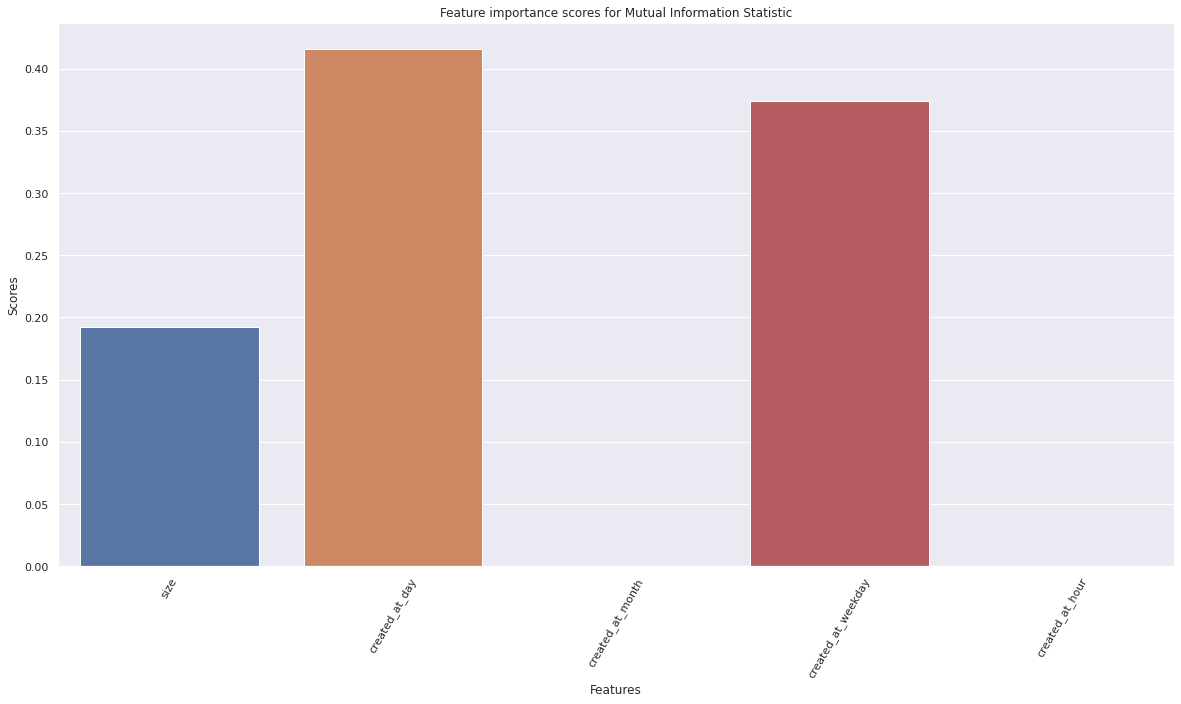

In [80]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [81]:
# Lets get a list of the top 10 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-10:][::-1]

In [82]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [83]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 18.833333
Feature created_at_day: 101.668378
Feature created_at_month: 8.529781
Feature created_at_weekday: 5.524096
Feature created_at_hour: 3.174790


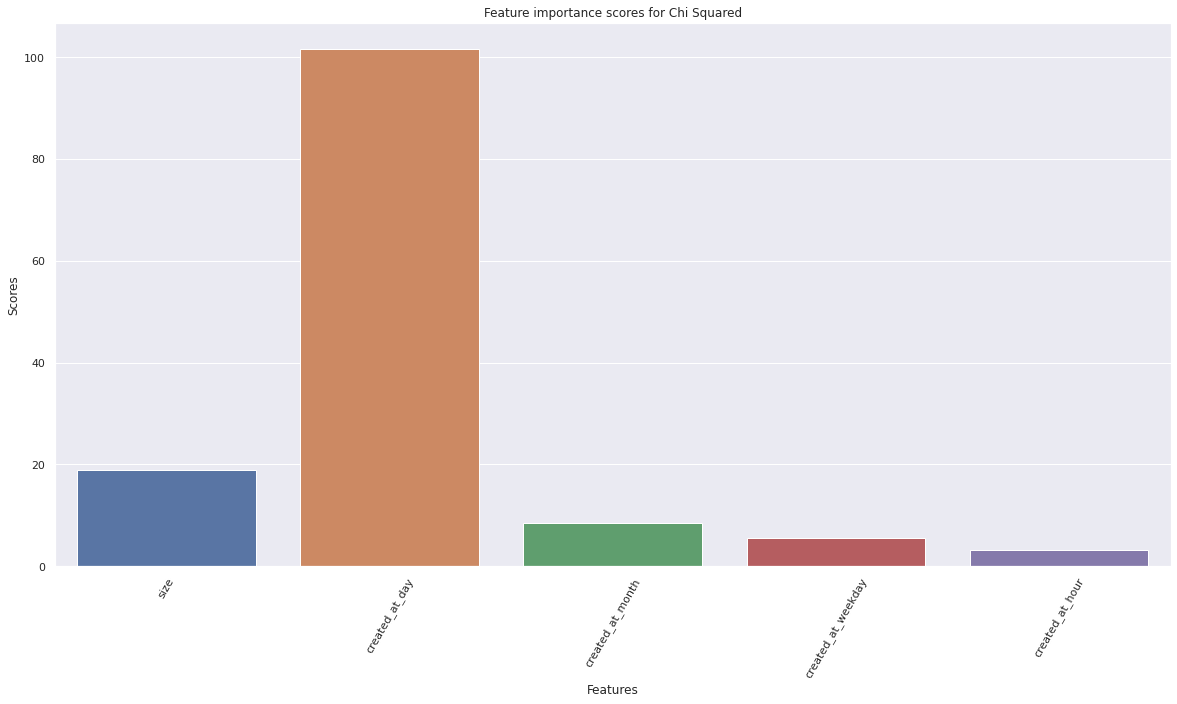

In [84]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [85]:
# Lets get a list of the top 10 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-10:][::-1]

Let's get a Union of the top 10 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [86]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 1, 2, 3, 4}

In [87]:
selected_cat_features = [cat_features[i] for i in union]
selected_cat_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour']

In [88]:
# update list of features to keep for training
selected_features += selected_cat_features

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [89]:
numerical_features = [
    "changed_files_number",
    "body_size",
    "commits_number",
    "ttm_class",
]

In [90]:
numerical_df = feature_df[numerical_features]
numerical_df.head()

,changed_files_number,body_size,commits_number,ttm_class
0,4,20,4,9
1,1,1,1,8
2,1,22,1,5
3,2,25,1,9
4,1,18,2,7


In [91]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

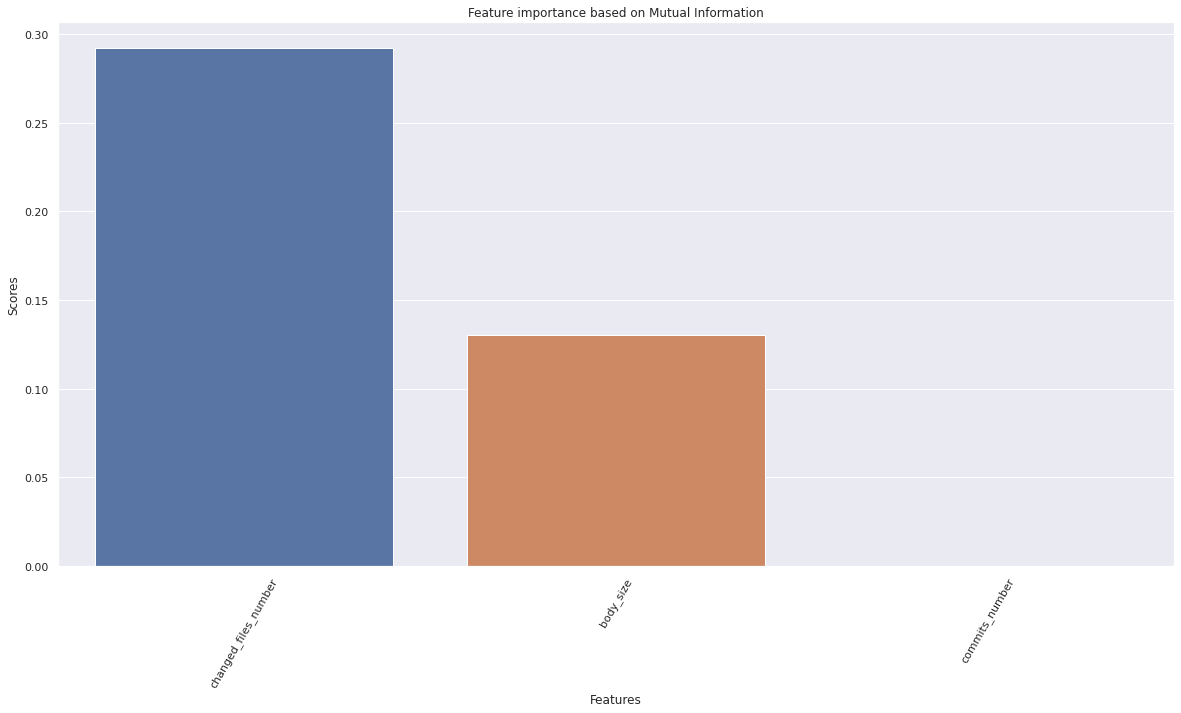

In [92]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

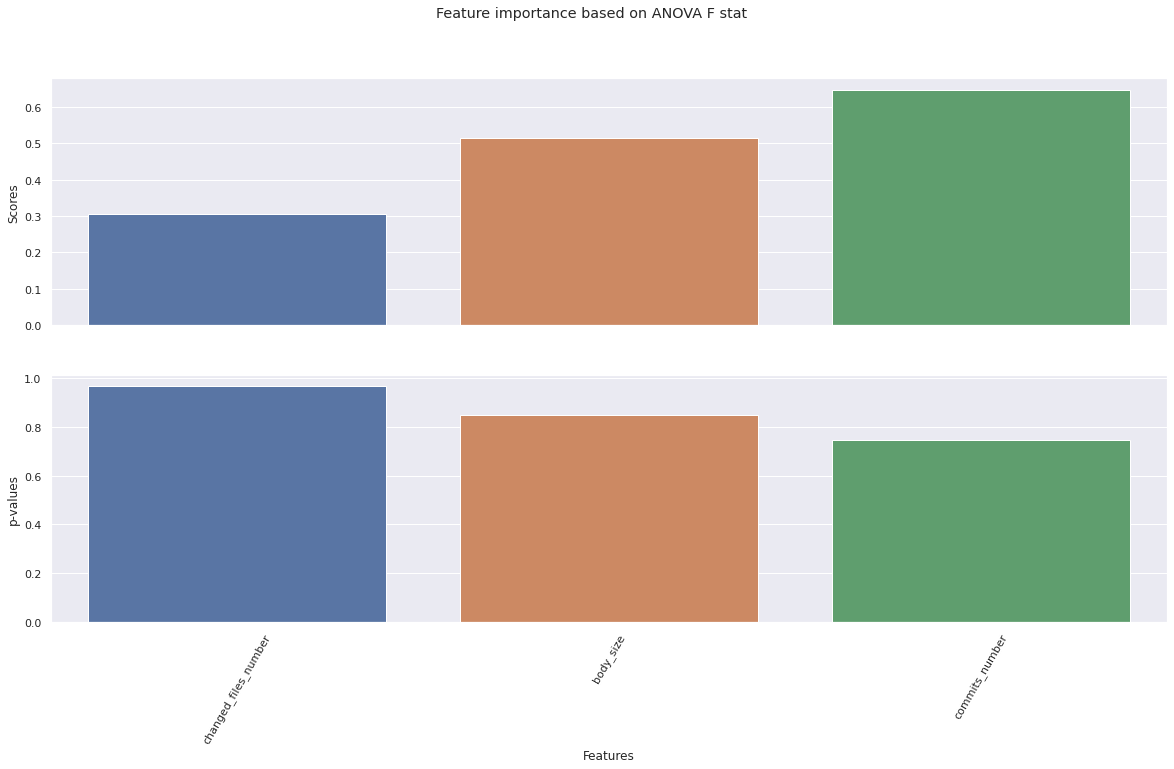

In [93]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

In [94]:
top_mi = k_best_selector_mi.scores_.argsort()[-3:][::-1]
top_anova = k_best_selector_f.scores_.argsort()[-3:][::-1]
union = set(top_mi).union(set(top_anova))
union

{0, 1, 2}

In [95]:
selected_num_features = [numerical_features[i] for i in union]
selected_num_features

['changed_files_number', 'body_size', 'commits_number']

In [96]:
# update list of features to keep for training
selected_features += selected_num_features

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [97]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [98]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_.md              0.341555
filetype_.txt             0.305969
filetype_.yaml            0.270440
filetype_LICENSE          0.186949
filetype_.ipynb           0.174425
filetype_.py              0.112959
filetype_Dockerfile      -0.088467
filetype_Containerfile   -0.143550
filetype_.yml            -0.190377
filetype_.sh             -0.421349
dtype: float64

In [99]:
corr[corr.abs() > 0.01]

filetype_.ipynb           0.174425
filetype_.yaml            0.270440
filetype_.py              0.112959
filetype_.yml            -0.190377
filetype_.sh             -0.421349
filetype_.md              0.341555
filetype_.txt             0.305969
filetype_LICENSE          0.186949
filetype_Dockerfile      -0.088467
filetype_Containerfile   -0.143550
dtype: float64

In [100]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
filetype_keep_cols = corr[corr.abs() > 0.01].index.tolist()
selected_features += filetype_keep_cols

# only keep the relevant columns now
filetype_df = filetype_df[filetype_keep_cols]

In [101]:
filetype_keep_cols = [i[9:] for i in filetype_keep_cols]
filetype_keep_cols

['.ipynb',
 '.yaml',
 '.py',
 '.yml',
 '.sh',
 '.md',
 '.txt',
 'LICENSE',
 'Dockerfile',
 'Containerfile']

In [102]:
filetype_keep_cols_df = pd.DataFrame(filetype_keep_cols, columns=["filetype"])

In [103]:
filetype_keep_cols_df

,filetype
0,.ipynb
1,.yaml
2,.py
3,.yml
4,.sh
5,.md
6,.txt
7,LICENSE
8,Dockerfile
9,Containerfile


In [106]:
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
filetype_keep_cols_df.to_parquet(FILETYPE_FEATURES_FILENAME)  # where to save it, usually as a .pkl


In [107]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [108]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_pr               0.315220
title_wordcount_workflow         0.268617
title_wordcount_functionality    0.268617
title_wordcount_notebook         0.186949
title_wordcount_sample           0.186949
                                   ...   
title_wordcount_condition       -0.308800
title_wordcount_size            -0.308800
title_wordcount_fixed           -0.308800
title_wordcount_prs             -0.308800
title_wordcount_train           -0.308800
Length: 74, dtype: float64

In [109]:
corr[corr.abs() > 0.04]

title_wordcount_action     -0.053468
title_wordcount_add         0.161313
title_wordcount_added       0.110325
title_wordcount_adding      0.131866
title_wordcount_api         0.132382
                              ...   
title_wordcount_upstream    0.186949
title_wordcount_use         0.186949
title_wordcount_version     0.186949
title_wordcount_workflow    0.268617
title_wordcount_yml        -0.198634
Length: 61, dtype: float64

In [110]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
title_word_keep_cols = corr[corr.abs() > 0.04].index.tolist()
selected_features += title_word_keep_cols

title_wordcount_df = title_wordcount_df[title_word_keep_cols]

In [111]:
title_word_keep_cols = [i[16:] for i in title_word_keep_cols]
title_word_keep_cols

['action',
 'add',
 'added',
 'adding',
 'api',
 'basic',
 'best',
 'branding',
 'callingprs',
 'changed',
 'choose',
 'clean',
 'cleanup',
 'comment',
 'condition',
 'data',
 'docs',
 'documentation',
 'download',
 'engineering',
 'entrypoint',
 'error',
 'feature',
 'fix',
 'fixed',
 'functionality',
 'github',
 'improve',
 'inputs',
 'latest',
 'marketplace',
 'merge',
 'messaging',
 'mode',
 'model',
 'modes',
 'notebook',
 'notebook3',
 'optimization',
 'point',
 'pr',
 'pre',
 'prs',
 'publishing',
 'pygithub',
 'rate',
 'refactored',
 'sample',
 'sh',
 'size',
 'srcopsmetrics',
 'testing',
 'train',
 'training',
 'trigger',
 'update',
 'upstream',
 'use',
 'version',
 'workflow',
 'yml']

In [112]:
title_word_keep_cols_df = pd.DataFrame(title_word_keep_cols, columns=["title"])

In [113]:
title_word_keep_cols_df

,title
0,action
1,add
2,added
3,adding
4,api
...,...
56,upstream
57,use
58,version
59,workflow


In [115]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")

title_word_keep_cols_df.to_parquet(TITLE_FEATURES_FILENAME)  # where to save it, usually as a .pkl


Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [116]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'commits_number',
 'filetype_.ipynb',
 'filetype_.yaml',
 'filetype_.py',
 'filetype_.yml',
 'filetype_.sh',
 'filetype_.md',
 'filetype_.txt',
 'filetype_LICENSE',
 'filetype_Dockerfile',
 'filetype_Containerfile',
 'title_wordcount_action',
 'title_wordcount_add',
 'title_wordcount_added',
 'title_wordcount_adding',
 'title_wordcount_api',
 'title_wordcount_basic',
 'title_wordcount_best',
 'title_wordcount_branding',
 'title_wordcount_callingprs',
 'title_wordcount_changed',
 'title_wordcount_choose',
 'title_wordcount_clean',
 'title_wordcount_cleanup',
 'title_wordcount_comment',
 'title_wordcount_condition',
 'title_wordcount_data',
 'title_wordcount_docs',
 'title_wordcount_documentation',
 'title_wordcount_download',
 'title_wordcount_engineering',
 'title_wordcount_entrypoint',
 'title_wordcount_error',
 'title_wordcount_feature',
 'title_wordcoun

## Save Feature Engineered Dataset

In [117]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.ipynb,filetype_.yaml,...,title_wordcount_training,title_wordcount_trigger,title_wordcount_update,title_wordcount_upstream,title_wordcount_use,title_wordcount_version,title_wordcount_workflow,title_wordcount_yml,ttm_class,time_to_merge
0,5,3,2,4,15,4,20,4,3,1,...,0,0,0,0,0,1,0,0,9,NaN
1,0,27,1,4,19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,8,242379.0
2,2,27,1,4,16,1,22,1,1,0,...,0,0,0,0,0,0,0,0,5,8554.0
3,3,12,1,3,19,2,25,1,1,0,...,0,0,0,0,0,0,0,0,9,502425.0
4,2,10,1,1,19,1,18,2,0,0,...,0,0,0,0,0,0,0,0,7,87972.0


In [118]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size                           33 non-null     int64  
 1   created_at_day                 33 non-null     int64  
 2   created_at_month               33 non-null     int64  
 3   created_at_weekday             33 non-null     int64  
 4   created_at_hour                33 non-null     int64  
 5   changed_files_number           33 non-null     int64  
 6   body_size                      33 non-null     int64  
 7   commits_number                 33 non-null     int64  
 8   filetype_.ipynb                33 non-null     int64  
 9   filetype_.yaml                 33 non-null     int64  
 10  filetype_.py                   33 non-null     int64  
 11  filetype_.yml                  33 non-null     int64  
 12  filetype_.sh                   33 non-null     int64

## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [122]:
ttm_dataset.to_parquet("ttm_feature_engineered_dataset.parquet")  # where to save it, usually as a .pkl

# Conclusion

This notebook walked through how to access saved raw Pull Requests data from the previous data collection notebook and we engineered some possible features which can be used to predict time to merge of a PR. 

The features we engineered are as following:

- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- size: integer corresponding to a categorical label generated by GitHub which summarizes the size of the changes made to the code base 
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commits in the PR
- changed_file_type_vec:  vector or list consisting of number of files changed for the top 100 most frequently occurring data types, derived from changed_files


# Next Step

In the next [notebook](./03_model_training.ipynb), we will train a classifier to predict time to merge of a PR using the features.